In [68]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

In [69]:
def cal_LLT(data, d):
    alpha = 2/(d+1)
    data['LLT'] = None
    LLT=[data['close'][0],data['close'][1]]
#     LLT=[0,0]
    for i in range(2,len(data['close'])):
        price_2 = data['close'][i-2]
        price_1 = data['close'][i-1]
        price = data['close'][i]
        LLT_2  = LLT[i-2]
        LLT_1  = LLT[i-1]
        LLT_t = (alpha-(alpha**2)/4)*price + (alpha**2)/2*price_1 \
                - (alpha-3/4*(alpha**2))*price_2+ 2*(1-alpha)*LLT_1 \
                - ((1-alpha)**2)*LLT_2
        LLT.append(LLT_t)
    data['LLT'] = LLT
    return data

In [70]:
def cal_MA(data, n):
    data['MA'] = None
    data['MA'][n-1:] = np.convolve(data["close"], np.ones(n) /n, 'valid')
    return data

In [71]:
def cal_EMA(data, a):
    data['EMA'] = None
    data['EMA'][0]=data['close'][0]
    for i in range(1,len(data['close'])):
        data['EMA'][i] = data['EMA'][i-1]*(1-a)+a*data['close'][i]
    return data

In [72]:
# cal_LLT(my_data, 39)[1734:1835]

In [73]:
def signal(data,n, strategy=1):
    direction = None
    data['signal']=None
    '''
    strategy=1 计算MA, n为阶数 只有计算MA用
    strategy=2 计算LLT
    '''
    
    if strategy ==1:
        for i in range(n,len(data['close'])):
            if direction == None:
                if data['MA'][i]>data['MA'][i-1]:
                    direction = 1
                    data['signal'][i] = 1
                elif data['MA'][i]<data['MA'][i-1]:
                    direction = -1
                    data['signal'][i] = -1
            elif direction == 1:
                if data['MA'][i]<data['MA'][i-1]:
                    direction = -1
                    data['signal'][i] = -1
            elif direction == -1:
                if data['MA'][i]>data['MA'][i-1]:
                    direction = 1
                    data['signal'][i] = 1
    
    elif strategy ==2:
        for i in range(1,len(data['close'])):
            if direction == None:
                if data['LLT'][i]>data['LLT'][i-1]:
                    direction = 1
                    data['signal'][i] = 1
                elif data['LLT'][i]<data['LLT'][i-1]:
                    direction = -1
                    data['signal'][i] = -1
            elif direction == 1:
                if data['LLT'][i]<data['LLT'][i-1]:
                    direction = -1
                    data['signal'][i] = -1
            elif direction == -1:
                if data['LLT'][i]>data['LLT'][i-1]:
                    direction = 1
                    data['signal'][i] = 1
    
    return  data

In [74]:
# signal(my_data)[0:50]

In [75]:
#持仓计算
def position(data, shift_period=1):
    signal = data['signal']
    position = signal.fillna(method='ffill').shift(shift_period).fillna(0)
    data['position'] = position
    return data

In [76]:
def statistic_performance(data, r0=0.03, data_period=1440, 
                          is_consider_open=False,
                          is_consider_stop=False,
                          is_daily_close = False,
                          point = None,
                          comm=None, leverage=None):
    position = data['position']
    close = data['close']
    open_p = data['open']
    
    d_first = data['date'].values[0]
    d_last = data['date'].values[-1]
    d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
    y_period = d_period.days / 365

    # 1. 初始化 
    hold_in_price =  close.shift(1).copy()
    hold_in_price[close.index[0]] = open_p.values[0]
    hold_out_price = close.copy()
              
    # 2. 若考虑持仓信号开盘才能操作
    if is_consider_open:
        # 仓位变动第一期的period_in_price为当日open
        hold_in_price[abs(position - position.shift(1).fillna(0))>0] = open_p
        # 仓位变动前最后一期的period_out_price为下一段的open (除了整个序列最后一天不变)
        hold_out_price[abs(position - position.shift(-1).fillna(0))>0] = open_p.shift(-1)
        hold_out_price[hold_out_price.index[-1]] = close.values[-1]
    
    #3.考虑止损+跳空 比较止损价和开盘价
    if is_consider_stop:
        for i in range(data.index[0],data.index[0]+len(data['close'])):
            if data["position"][i]<0 and data['stop_or_not'][i] == True:#只有止损平仓stop_or_not是True 15:00:00平仓是False
                hold_out_price[i] = max(data['stop_price'][i],data['open'][i])            
            elif data["position"][i]>0 and data['stop_or_not'][i] == True:
                hold_out_price[i] = min(data['stop_price'][i],data['open'][i])

    #4.是否收盘前平仓
    if is_daily_close:
        daily_last_idxes = data.drop_duplicates(subset='date',keep='last').index
        #距离每天最后一个时间点的距离 如15:00:00平仓 15:15:00截止  5m一段 hold_out_price.loc[daily_last_idxes.values-3]=close
        hold_out_price.loc[daily_last_idxes.values] = close 
    
    #5.考虑指数点
    if point:
        # 仓位变动第一期的period_in_price long加指数点 short减指数点
        hold_in_price[position < position.shift(1).fillna(0)] = hold_in_price - point
        hold_in_price[position > position.shift(1).fillna(0)] = hold_in_price + point       
        # 仓位变动前最后一期的period_out_price long减指数点 short加指数点
        hold_out_price[position < position.shift(-1).fillna(0)] = hold_out_price + point
        hold_out_price[position > position.shift(-1).fillna(0)] = hold_out_price - point
           
    # 6. 计算收益
    hold_r = position * (hold_out_price/hold_in_price-1)

    # 7. 考虑换仓成本 
    if comm:
        chgpos_comm_perc = (1-comm)**abs(position - position.shift(1).fillna(0)) 
        hold_r = chgpos_comm_perc * (1+hold_r) - 1 
    # 8. 考虑杠杆 
    if leverage:
        hold_r *= leverage

    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()      
    ex_hold_r= hold_r-r0/(250*1440/data_period)
    data['hold_in_price'] = hold_in_price *abs(position)
    data['hold_out_price'] = hold_out_price *abs(position)
    data['hold_r'] = hold_r
    data['hold_win'] = hold_win
    data['hold_cumu_r'] = hold_cumu_r
    data['drawdown'] = drawdown
    data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        
        v_max_dd：              最大回撤
        v_annual_ret：          年化收益
        v_sharpe：              年化夏普
    """
    v_hold_cumu_r = hold_cumu_r.tolist()[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    for w, r, pre_pos, pos in zip(hold_win, hold_r, position.shift(1), position):
        """ 当日有换仓（先结算上一次持仓，再初始化本次持仓） """
        if pre_pos!=pos: 
            # 判断pre_pos非空：若为空则是循环的第一次，此时无需结算，直接初始化持仓即可
            if pre_pos == pre_pos:
                # 结算上一次持仓
                if pre_pos>0:
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                elif pre_pos<0:
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
            # 初始化本次持仓
            tmp_hold_r = r
            tmp_hold_period = 0
            tmp_hold_win_period = 0
        else: 
            if abs(pos)>0:
                tmp_hold_period += 1
                if r>0:
                    tmp_hold_win_period += 1
                if abs(r)>0:
                    tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()    
    v_annual_std = ex_hold_r.std() * np.sqrt( len(data)/y_period ) 
    v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    performance_cols = ['累计收益', 
                        '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                        '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                        '周期胜率', '最大回撤', '年化收益/最大回撤',
                        '年化收益','年化标准差', '年化夏普'
                       ]
    performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                          v_pos_hold_times, v_pos_hold_win_times,
                                            '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times if v_pos_hold_times != 0 else 0), 
                                            '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times if v_pos_hold_times != 0 else 0),
                          v_neg_hold_times, v_neg_hold_win_times,
                                            '{:.2%}'.format(v_neg_hold_win_times / v_neg_hold_times if v_neg_hold_times != 0 else 0), 
                                            '{:.2f}'.format(v_neg_hold_period / v_neg_hold_times if v_neg_hold_times != 0 else 0),
                          '{:.2%}'.format(v_hold_win_period/v_hold_period if v_neg_hold_period != 0 else 0), 
                          '{:.2%}'.format(v_max_dd), 
                          '{:.2f}'.format(v_annual_ret/v_max_dd),
                          '{:.2%}'.format(v_annual_ret), 
                          '{:.2%}'.format(v_annual_std),
                          '{:.2f}'.format(v_sharpe)
                         ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    
    return data, performance_df, hold_cumu_r

In [77]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [78]:
def visualize_performance(data):
    if 'trade_date' in data:
        data['trade_datetime'] = data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
        dt = data['trade_datetime']
    else:
        dt = [datetime.datetime.strptime('{}'.format(d), '%Y-%m-%d') 
              for d in data['date']]

    f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)


    # 绘制行情
    close = data['close']
    cumu_hold_close = (data['hold_cumu_r']+1) * close.tolist()[0]
    f1.line(dt, close, line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )


    # 绘制仓位
    position = data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = data['hold_r']
    hold_cumu_r = data['hold_cumu_r']+1
    f3.line(dt, hold_cumu_r, line_width=1, color='red')
#     f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   #[indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

In [114]:
#读取数据
my_data =pd.read_csv(
    '000001.XSHG_2013.csv', sep=',', parse_dates=True)
my_data = my_data.iloc[:, 0:3]
my_data
# print(my_data['close'][2:4].mean())
# print(my_data['close'][2:4])

,date,open,close
0,2005-09-06,1197.23,1173.32
1,2005-09-07,1170.77,1194.31
2,2005-09-08,1196.27,1194.41
3,2005-09-09,1194.49,1189.63
4,2005-09-12,1189.75,1188.21
...,...,...,...
1889,2013-06-24,2068.86,1963.23
1890,2013-06-25,1948.32,1959.51
1891,2013-06-26,1954.47,1951.49
1892,2013-06-27,1955.13,1950.01


In [112]:
my_data = cal_LLT(my_data, 39)
my_data = cal_MA(my_data, 30)
my_data = cal_EMA(my_data, 0.05)
my_data[1734:1835]

,date,open,close,LLT,MA,EMA
1734,2012-10-26,2100.10,2066.21,2082.050811,2089.81,2099.6
1735,2012-10-29,2061.85,2058.94,2079.229346,2087.28,2097.56
1736,2012-10-30,2059.20,2062.35,2076.450751,2085.34,2095.8
1737,2012-10-31,2061.12,2068.88,2074.394341,2083.41,2094.46
1738,2012-11-01,2070.02,2104.43,2074.594183,2083.22,2094.96
...,...,...,...,...,...,...
1830,2013-03-21,2318.20,2324.24,2335.264912,2340.12,2304.36
1831,2013-03-22,2321.40,2328.28,2335.907654,2337.1,2305.56
1832,2013-03-25,2334.74,2326.72,2336.586059,2333.72,2306.62
1833,2013-03-26,2318.58,2297.67,2335.664235,2329.2,2306.17


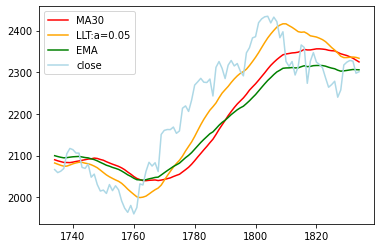

In [108]:
# 设置图例样式
plt.plot(my_data['MA'][1734:1835],label="MA30",color='red')
plt.plot(my_data['LLT'][1734:1835],label='LLT:a=0.05',color='orange')
plt.plot(my_data['EMA'][1734:1835],label='EMA',color='green')
plt.plot(my_data['close'][1734:1835],label='close',color='lightblue')
plt.legend(loc='best')
plt.show()

In [109]:
def indicator_show(data):
    f = figure(height=300, width=700, 
                sizing_mode='stretch_width', 
                title='Indicator Comparison',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")

    dt = data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    

    close = data['close']
    MA30 = data['MA']
    EMA = data['EMA']
    LLT = data['LLT']

    f.line(dt, close, line_width=1, color='black', legend_label='close')
    f.line(dt, MA30, line_width=1, color='orange', legend_label='MA30')
    f.line(dt, EMA, line_width=1, color='blue', legend_label='EMA')
    f.line(dt, LLT, line_width=1, color='red', legend_label='LLT')

    show(f)
indicator_show(my_data)

In [110]:
#计算MA30下收益
my_data = cal_MA(my_data, 30)
my_signal = signal(my_data,30,strategy=1)
my_position = position(my_signal)
# my_position[59:100]
list1=[]
res_my_data, performance_df,list1 = statistic_performance(my_position, 
                                                   data_period=1, 
                                                   is_consider_open=False,
                                                   is_consider_stop = False,                       
                                                   is_daily_close=False
                                                   )
print(performance_df)
# res_my_data[90:140]
visualize_performance(res_my_data)

                 0
累计收益       322.36%
多仓次数            57
多仓成功次数          18
多仓胜率        31.58%
多仓平均持有期      16.63
空仓次数            57
空仓成功次数          20
空仓胜率        35.09%
空仓平均持有期      13.86
周期胜率        54.80%
最大回撤        41.70%
年化收益/最大回撤     0.49
年化收益        20.25%
年化标准差       27.50%
年化夏普          0.74


In [113]:
#计算LLT下收益（0.05）
my_data = cal_LLT(my_data, 59)
my_signal = signal(my_data,59,strategy=2)
my_position = position(my_signal)
res_my_data, performance_df,list_20 = statistic_performance(my_position, 
                                                   data_period=1, 
                                                   is_consider_open=False,
                                                   is_consider_stop = False,                       
                                                   is_daily_close=False
                                                   )
print(performance_df)
visualize_performance(res_my_data)
# res_my_data[0:50]

                 0
累计收益       540.08%
多仓次数            51
多仓成功次数          19
多仓胜率        37.25%
多仓平均持有期      18.75
空仓次数            50
空仓成功次数          17
空仓胜率        34.00%
空仓平均持有期      16.44
周期胜率        55.55%
最大回撤        40.02%
年化收益/最大回撤     0.67
年化收益        26.82%
年化标准差       27.56%
年化夏普          0.97


In [115]:
i=0
for d in [20,30,40,50,60,70,80,90]:
    my_data = cal_LLT(my_data, d)
    my_signal = signal(my_data,d,strategy=2)
    my_position = position(my_signal)
    res_my_data, performance_df,list1 = statistic_performance(my_position, 
                                                       data_period=1, 
                                                       is_consider_open=False,
                                                       is_consider_stop = False,
                                                       is_daily_close=False)
#     print(list1)
    if i ==0:
        df = pd.DataFrame(pd.Series(list1),columns=["LLT_{}".format(d)])
    else:
        df["LLT_{}".format(d)]=list1
    i+=1
df.index=my_data['date']       


In [116]:
df

,LLT_20,LLT_30,LLT_40,LLT_50,LLT_60,LLT_70,LLT_80,LLT_90
date,,,,,,,,
2005-09-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-09-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-09-08,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084
2005-09-09,-0.003919,-0.003919,-0.003919,-0.003919,-0.003919,-0.003919,-0.003919,-0.003919
2005-09-12,-0.005108,-0.005108,-0.005108,-0.005108,-0.005108,-0.005108,-0.005108,-0.005108
...,...,...,...,...,...,...,...,...
2013-06-24,5.633733,11.183482,9.573469,5.274641,5.965741,6.364000,6.868792,3.694915
2013-06-25,5.646303,11.206567,9.593504,5.286530,5.978940,6.377954,6.883702,3.703811
2013-06-26,5.673505,11.256527,9.636861,5.312260,6.007504,6.408151,6.915969,3.723063


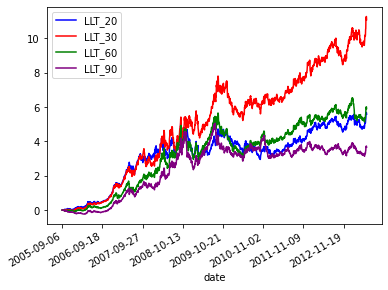

In [119]:
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator


fig, ax = plt.subplots()

df['LLT_20'].plot(color='blue')
df['LLT_30'].plot(color='red')
df['LLT_60'].plot(color='green')
df['LLT_90'].plot(color='purple')
plt.legend(loc='best')


# ax = plt.gca()
# ax.xaxis.set_major_locator(YearLocator(month=9, day=5))
# ax.xaxis.set_major_locator(YearLocator())
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
# plt.gcf().autofmt_xdate()

for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')


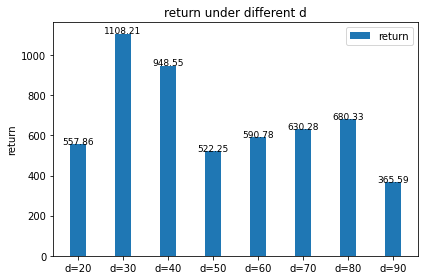

In [124]:
labels = ['d=20', 'd=30',  'd=40',  'd=50', 'd=60', 'd=70', 'd=80', 'd=90']
d = [557.8560,1108.2150,948.5528,522.2454,590.7806,630.2753,680.3347,365.5867]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x ,d, width, label='return')
ax.set_ylabel('return')
ax.set_title('return under different d')
ax.set_xticks(x)
ax.set_xticklabels(['d=20', 'd=30',  'd=40',  'd=50', 'd=60', 'd=70', 'd=80', 'd=90'])
for a,b,i in zip(x,d,range(len(x))): # zip 函数
    plt.text(a,b+0.1,"%.2f"%d[i],ha='center',fontsize=9) # plt.text 函数
ax.legend()
fig.tight_layout()
plt.show()

In [103]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [104]:
def visualize_performance(data,strategy=1):
    if 'trade_date' in data:
        data['trade_datetime'] = data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
        dt = data['trade_datetime']
    else:
        if strategy ==1:
            dt = [datetime.datetime.strptime('{} '.format(d), '%Y-%m-%d ') 
                for d in data['date']]
        elif strategy ==2:
            dt = [datetime.datetime.strptime('{} {}'.format(d, t), '%Y-%m-%d %H:%M:%S') 
                  for d, t in zip(data['date'], data['time'])]

    f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)


    # 绘制行情
    close = data['close']
    cumu_hold_close = (data['hold_cumu_r']+1) * close.tolist()[0]
    f1.line(dt, close, line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )


    # 绘制仓位
    position = data['position']
    if strategy == 2:
        position = data['new_position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = data['hold_r']
    hold_cumu_r = data['hold_cumu_r']+1
    f3.line(dt, hold_cumu_r, line_width=1, color='red')

    # 绘制回撤
    drawdown = data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    p = gridplot([ [f1],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)